### Spain Weather Analysis 
To make the successful transition to renewable energy, forecasting is commonly used in the energy markets to understand energy demand as well as energy generation under certain weather or seasonal trend. The use of machine learning on time series datasets is highly leveraged to understand these dynamics. 

The goal of this analysis is to practice data preprocessing, implement algorithms on time series dataset, and evaluate models using different metrics. 

This notebook presents the process of exploring the weather dataset.

In [ ]:
# command shell
import IPython
import IPython.display

# data analysis, wrangling and preprocessing
import numpy as np 
import pandas as pd 
import datetime 

# data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import plotnine as p9 
import folium 
import geopy.distance
plt.style.use('fivethirtyeight') 

# Combinatorics 
from itertools import combinations 

# data preprocessing
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# time series modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm

# LSTM
import tensorflow as tf

# model evaluation
# from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

### Loading data 
We start by loading the dataset into Pandas DataFrames.

In [ ]:
weather = pd.read_csv('weather_features.csv')
weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

Here is a brief description of each column:
* `dt_iso`: date time index localized to CET
* `city_name`: the name of the city
* `temp`: the temperature record in kelvin (have to change it to fahrenheit)
* `temp_min`: the minimum temperature in kelvin
* `temp_max`: the maximum temperature in kelvin
* `pressure`: the pressure in Hectopascal (have to change it to Pascal)
* `humidity`: humidity in percentage
* `wind_speed`: wind speed in meter per second
* `wind_deg`: the direction of the wind
* `rain_1h`: rain in last hour in millimeter
* `rain_3h`: rain in last three hours in millimeter
* `snow_3h`: snow in last three hours in millimeter
* `clouds_all`: cloud coverage in percentage
* `weather_id`: code used to describe weather
* `weather_main`: short description of the current weather
* `weather_description`: long description of the current weather
* `weather_icon`: weather icon code 

Using the info function to check if there is any missing values in this dataset.

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

There is no NaNs in the `weather` dataset. However, we will dig into each column to determine whether all data points are valid and not just missing values fill in with zeros. 

### Data Cleaning
Taking a inital peek at the `weather` dataset using head method and identify some things we have to do before exploratory data analysis (EDA) for the time series data.

In [ ]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


There are several things we have to do:
* Strip the white space for the `city_name` column
* Change the `dt_iso` to date format
* Convert the unit of all temperature columns from kelvin into Fahrenheit
* Decide if there is any dulicate columns between `weather_id`, `weather_main`, `weather_description`, and `weather_icon`

Strip the white space for the `city_name` column

In [ ]:
weather['city_name'] = weather['city_name'].str.strip()

Change the format of the date to datetime object and creating several columns with different time granularity. This will help us in the EDA phase later on.

In [ ]:
weather.rename(columns={'dt_iso':'time'}, inplace=True)
weather['time'] = pd.to_datetime(weather['time'], utc=True)
# weather = weather.set_index('time')
# weather['Year'] = weather['dt_iso'].dt.year
# weather['Year-Month'] =  weather['dt_iso'].dt.strftime('%Y-%m')
# weather['Year-Month-Day'] =  weather['dt_iso'].dt.strftime('%Y-%m-%d')
# weather['Day'] = weather['dt_iso'].dt.day

In [ ]:
weather['time'] = weather['time'].dt.strftime('%d/%m/%y %H:%M')
weather['time'] = pd.to_datetime(weather['time'])

In [ ]:
weather['time'].head()

0   2014-12-31 23:00:00
1   2015-01-01 00:00:00
2   2015-01-01 01:00:00
3   2015-01-01 02:00:00
4   2015-01-01 03:00:00
Name: time, dtype: datetime64[ns]

Next, convert the unit of all the temperature columns, including `temp`, `temp_min`, and `temp_max` from Kelvin to Fahrenheit.

In [ ]:
def K_to_F(k):
    f = np.round((k - 273.15) * 9 / 5 + 32, 3)
    return f
weather['temp'] = weather['temp'].apply(lambda x : K_to_F(x))
weather['temp_min'] = weather['temp_min'].apply(lambda x : K_to_F(x))
weather['temp_max'] = weather['temp_max'].apply(lambda x : K_to_F(x))

Try to identify the relationship between `weather_id`, `weather_main`, `weather_description`, and `weather_icon`

In [ ]:
aList = ['weather_id', 'weather_main', 'weather_description', 'weather_icon']
for item in aList:
    print(weather[item].value_counts().head(10))

800    82685
801    32101
803    17448
802    15945
500    10905
701     3908
501     3625
804     2561
741     2506
300     1241
Name: weather_id, dtype: int64
clear           82685
clouds          68055
rain            17391
mist             3908
fog              2506
drizzle          1724
thunderstorm     1041
haze              435
dust              347
snow              270
Name: weather_main, dtype: int64
sky is clear               82685
few clouds                 32101
broken clouds              17448
scattered clouds           15945
light rain                 10905
mist                        3908
moderate rain               3621
overcast clouds             2561
fog                         2506
light intensity drizzle     1241
Name: weather_description, dtype: int64
01n    38541
01d    34830
02d    19199
02n    12368
04d     9137
04n     8403
03d     7870
10n     5951
01      5946
03n     5833
Name: weather_icon, dtype: int64


By using value_counts method, we are able to identify `weather_id` as the coded column of `weather_description`. We decide to drop `weather_icon` and `weather_id` columns. This is because `weather_icon` does not have provide any additional information for the weather condition and `weather_id` is nominal, which won't be helpful in the modeling process. `weather_main` provided a more concise version of the `weather_description` column, which will be useful when we want to look at the weather condition on a higher level.

In [ ]:
weather.drop(columns=['weather_id','weather_description', 'weather_icon'], inplace=True)

### Exploratory Data Analysis
We use exploratory data analysis (EDA) to identify irregularities, patterns and possible relationships across time between variables within the given dataset. If helps us determine variables that we could use in our models and identify what preprocessing steps we have to do before putting them into the model.

* We will start off with **univariate analysis**, planning to understand the distribution of the underlying variable individually, such as the geographic location and other weather columns across time. During this process, we can identify if there are any outliers or other abnormalies we have to deal with before putting the data into the models. Also, we want to see what are some key difference between each given city.
* Next, we will perform missingness analysis where we identify potential missing values in this dataset, use statistical testing to determine whether the missingness are dependent, and come up wit appropriate method to replace it.
* Then, we will conduct bivariate analysis between the variables and decide what are some things that we could model using the given dataset.
We will start off by identify the different cities that are in this dataset.

#### Data Inspection and Cleaning
We use the describe method to inspect the general statistics of each numerical columns.

In [ ]:
round(weather.describe().transpose(), 3)

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,61.643,14.447,12.362,50.936,60.8,71.600,108.410
temp_min,178396.0,59.325,14.320,12.362,48.801,59.0,69.044,107.600
temp_max,178396.0,64.294,15.502,12.362,52.700,62.6,75.200,118.400
pressure,178396.0,1069.261,5969.632,0.000,1013.000,1018.0,1022.000,1008371.000
humidity,178396.0,68.423,21.903,0.000,53.000,72.0,87.000,100.000
wind_speed,178396.0,2.471,2.096,0.000,1.000,2.0,4.000,133.000
wind_deg,178396.0,166.591,116.612,0.000,55.000,177.0,270.000,360.000
rain_1h,178396.0,0.075,0.399,0.000,0.000,0.0,0.000,12.000
rain_3h,178396.0,0.000,0.007,0.000,0.000,0.0,0.000,2.315
snow_3h,178396.0,0.005,0.223,0.000,0.000,0.0,0.000,21.500


Analyzing categorical columns

In [ ]:
cities = list(weather['city_name'].unique())

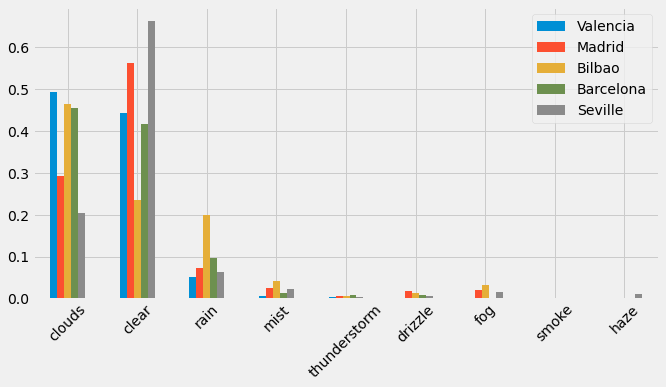

In [ ]:
weather_count = pd.DataFrame()

for city in cities:
    weather_count[city] = np.round(weather[weather['city_name'] == city].weather_main.value_counts(normalize=True), 5)
weather_count.plot(kind='bar')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(10, 5)

According to the plot above, there are several weather conditions (`weather_main`) that rarely happens over the time span of this dataset. We will use masking to classify them as `other`.

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py/lib/python3.7/site-packages/pa

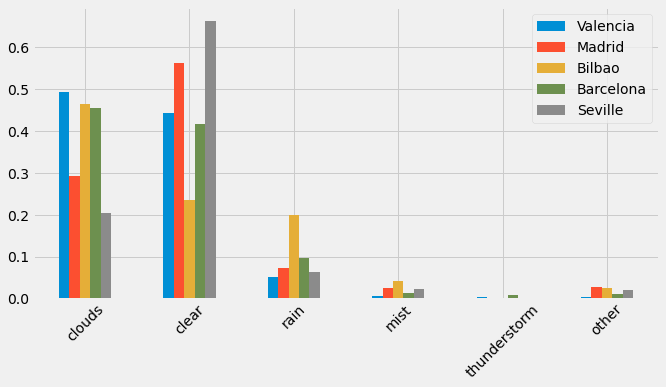

In [ ]:
weather_count = pd.DataFrame()
for city in cities:
    c = weather[weather['city_name'] == city]
    city_freq = c['weather_main'].value_counts()/c['weather_main'].shape[0]
    bottom_10 = city_freq.quantile(q=0.4)
    less_freq = city_freq[city_freq <= bottom_10]
    # print(less_freq.index.tolist())
    c['weather_main'].loc[c['weather_main'].isin(less_freq.index.tolist())] = "other"
    weather_count[city] = np.round(c.weather_main.value_counts(normalize=True), 5)
weather_count.plot(kind='bar')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(10, 5)

We can see the overall weather pattern for the last four years for each city. We will relate these to the actual geographic locations for these cities. 

In [ ]:
weather['city_name'].value_counts()

Madrid       36267
Bilbao       35951
Seville      35557
Barcelona    35476
Valencia     35145
Name: city_name, dtype: int64

There are 5 different cities (Madrid, Bilbao, Seville, Barcelona, and Valencia) with similar amount of data that are available to them. We will use inner join later on to sync the time for all cities.

Create a dataframe for each city:

In [ ]:
Madrid = weather[weather['city_name'] == 'Madrid']
Valencia = weather[weather['city_name'] == 'Valencia']
Bilbao = weather[weather['city_name'] == 'Bilbao']
Barcelona = weather[weather['city_name'] == 'Barcelona']
Seville = weather[weather['city_name'] == 'Seville']

### Distance Analysis
We want to plot the geographic location on the map, which will help us get a better understanding of the weather consition of these cities. Then, we use **Euclidean Distance** between two times series to compare the similarity. We hypothesize that there is a correlation between the real distance between two cities and the  

In [ ]:
city_list = ['Valencia', 'Madrid', 'Bilbao', 'Barcelona', 'Seville']
# enter the latitude and longitude for each city
lat = [39.469906,40.416775,43.2630,41.3851,37.3891]
lon = [-0.376288,-3.703790,-2.9350,2.1734,-5.9845]
geo_dict = {'city' : city_list,'latitude' : lat,'longitude' : lon}
geo = pd.DataFrame(data=geo_dict)
locations = geo[['latitude', 'longitude']]
locationlist = locations.values.tolist()
m = folium.Map(location=[40.4637, -3.7492], zoom_start = 6, tiles = 'Stamen Terrain')
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=geo['city'][point]).add_to(m)
m

As we can see on the map above, we have data from these 5 Spainish cities, where 4 of them (`Valencia`, `Bilbao`, `Barcelona`, `Seville`) are close to coastal area and `Madrid` is the only city that locates inland. We developed some hypotheses that will guide use through the next part of the EDA:
* Due to the fact that water has higher heat capacity than rock and sand, we expect coastal cities to have a more moderate temperature or less range of fluctuations in the change in temperature both throughout the day and across the year
* Some factors that influence atmospheric pressures are temperature and altitude. We expect cities with the higher altitude to have lower atmospheric pressure under the same temperature. At the same time,when the temperature of the two cities are the same, we expect the city with lower atmospheric pressure to have higher altitude.
    - When the temperature of a place increases, the atmospheric pressure decreases. This is because an increase in temperature results in heating of the air and warm air expends. 
    - Atmospheric pressure decreases with an increase in the altitude. Air is dragged to the ground by gravity. The lowest layer of air becomes the densest. 
* Coastal cities have much higher humidity than the inland city
* Coastal climates tend to have wetter winters and drier summers, whereas inland climates have more humid summers and drier winters. 

#### Real distance between two cities

In [ ]:
# Create a column called geometry from the latitude and longitude column
geo = pd.DataFrame(data=geo_dict)
geo['geometry'] = geo.apply(lambda x: (x.longitude, x.latitude), axis = 1)

# Create a list that contains the combination of all the cities 
aList = []
comb = combinations(cities, 2)
for i in list(comb):
    aList.append(i)

# Create a dictionary that contains the real distance between each city 
realDist = {}
for item in aList:
    city1 = item[0]
    city2 = item[1]
    loc1 = geo[geo['city'] == city1]['geometry']
    loc2 = geo[geo['city'] == city2]['geometry']
    dist = geopy.distance.geodesic(loc1,loc2)
    distance_in_km = dist.meters / 1000
    realDist[item] = distance_in_km
distance = pd.Series(realDist).to_frame(name = 'Real Distance')
distance

Real Distance
Valencia  Madrid        382.719626
          Bilbao        508.097842
          Barcelona     353.440425
          Seville       661.839247
Madrid    Bilbao        327.534440
          Barcelona     658.742773
          Seville       419.980312
Bilbao    Barcelona     602.277829
          Seville       733.895330
Barcelona Seville      1005.521033

### Visualize `temp` for different cities

In [ ]:
weather.head()

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main
0,2014-12-31 23:00:00,Valencia,27.185,27.185,27.185,1001,77,1,62,0.0,0.0,0.0,0,clear
1,2015-01-01 00:00:00,Valencia,27.185,27.185,27.185,1001,77,1,62,0.0,0.0,0.0,0,clear
2,2015-01-01 01:00:00,Valencia,25.765,25.765,25.765,1002,78,0,23,0.0,0.0,0.0,0,clear
3,2015-01-01 02:00:00,Valencia,25.765,25.765,25.765,1002,78,0,23,0.0,0.0,0.0,0,clear
4,2015-01-01 03:00:00,Valencia,25.765,25.765,25.765,1002,78,0,23,0.0,0.0,0.0,0,clear


In [ ]:
temp = pd.pivot_table(weather, values='temp', columns='city_name', index='time')
temp.head()

city_name,Barcelona,Bilbao,Madrid,Seville,Valencia
time,,,,,
2014-12-31 23:00:00,47.255,25.713,21.515,32.405,27.185
2015-01-01 00:00:00,47.255,25.904,21.515,32.405,27.185
2015-01-01 01:00:00,46.645,24.983,19.465,33.685,25.765
2015-01-01 02:00:00,46.645,24.896,19.465,33.685,25.765
2015-01-01 03:00:00,46.645,25.404,19.465,33.685,25.765


In [ ]:
temp = pd.pivot_table(weather, values='temp', columns='city_name', index='time')
monthly_temp = temp.resample('M').mean()
fig = px.line(monthly_temp)
fig.show()

### Analyzing `temp` for `Madrid`

In [ ]:
Madrid.set_index('time', inplace=True)
Madrid = Madrid[Madrid.index.year != 2014]
index_yaer = Madrid.index.year
index_month = Madrid.index.month
temperature_by_month = Madrid.groupby([index_yaer, index_month])['temp'].mean()

fig = px.line(temperature_by_month.unstack(level=0))
fig.show()

### Euclidean distance of `temp` between two cities

In [ ]:
def dist(dataframe, col):
    tmp = pd.pivot_table(dataframe, values=col, columns='city_name', index='time')
    aDict = {}
    for i in aList:
        x = pd.Series(tmp[i[0]])
        y = pd.Series(tmp[i[1]])
        aDict[i] = np.sqrt(np.sum([(a-b)**2 for a, b in zip(x, y)])) 
    return dict(sorted(aDict.items(), key=lambda item: item[1]))

In [ ]:
temp = pd.Series(dist(weather, 'temp')).to_frame(name = 'temp distance')
comp = distance.join(temp, how = 'inner')
print(comp)
fig = px.scatter(comp, x = 'Real Distance', y = 'temp distance',
                title="Real Distance vs Euclidean distance between two cities")
fig.show()

                     Real Distance  temp distance
Valencia  Madrid        382.719626    1598.799467
          Bilbao        508.097842    1948.613918
          Barcelona     353.440425    1018.267773
          Seville       661.839247    1605.010915
Madrid    Bilbao        327.534440    1715.009108
          Barcelona     658.742773    1557.272835
          Seville       419.980312    2107.921407
Bilbao    Barcelona     602.277829    1648.511030
          Seville       733.895330    2748.389548
Barcelona Seville      1005.521033    1843.491130


In [ ]:
aDict = {}
def adf(df, column_list):
    for column in column_list:
        result = adfuller(df[column], autolag='AIC')
        if result[1] < 0.05:
            print(f'Reject null hypothesis, {column} is stationary')
        else:
            print(f'Fail to reject null hypothesis, {column} needs to be differenced')
        aDict[column] = [round(result[0], 5), result[1]]

In [ ]:
temp = pd.pivot_table(weather, values='temp', columns='city_name', index='time')
adf(temp, temp.columns)

Reject null hypothesis, Barcelona is stationary
Reject null hypothesis, Bilbao is stationary
Reject null hypothesis, Madrid is stationary
Reject null hypothesis, Seville is stationary
Reject null hypothesis, Valencia is stationary


In [ ]:
stats = pd.DataFrame(aDict)
stats = stats.transpose()
stats.columns = ['ADF Statistic', 'p-value']
stats

,ADF Statistic,p-value
Barcelona,-14.75380,2.461629e-27
Bilbao,-14.44971,7.132022e-27
Madrid,-14.24457,1.517277e-26
Seville,-13.68647,1.369407e-25
Valencia,-13.74829,1.062291e-25


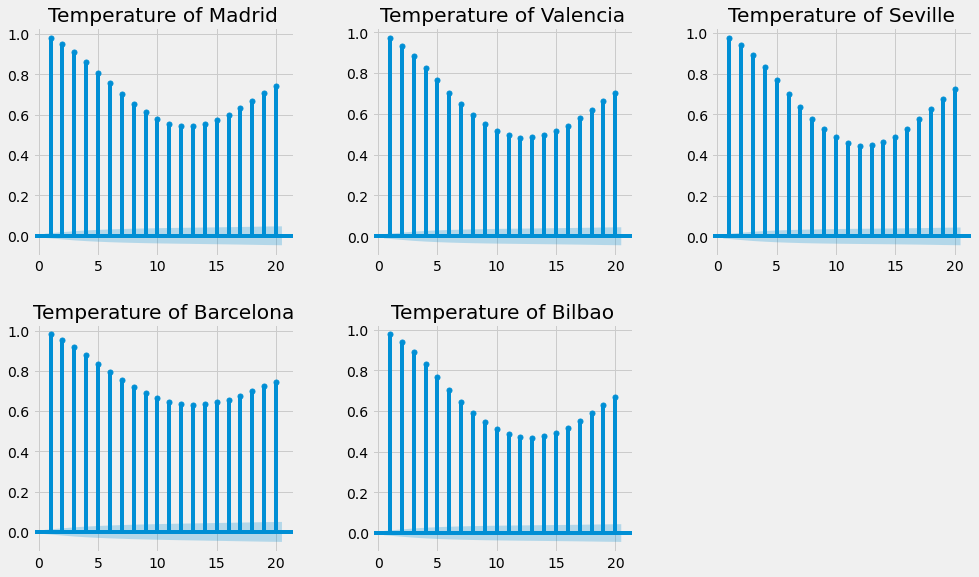

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,9))

x = plot_acf(temp['Madrid'], alpha=0.05, lags=20, zero=False, ax = axs[0,0])
axs[0,0].set_title('Temperature of Madrid')

x = plot_acf(temp['Valencia'], alpha=0.05, lags=20, zero=False, ax = axs[0,1])
axs[0,1].set_title('Temperature of Valencia')

x = plot_acf(temp['Seville'], alpha=0.05, lags=20, zero=False, ax = axs[0,2])
axs[0,2].set_title('Temperature of Seville')

x = plot_acf(temp['Barcelona'], alpha=0.05, lags=20, zero=False, ax = axs[1,0])
axs[1,0].set_title('Temperature of Barcelona')

x = plot_acf(temp['Bilbao'], alpha=0.05, lags=20, zero=False, ax = axs[1,1])
axs[1,1].set_title('Temperature of Bilbao')

axs[1,2].remove()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

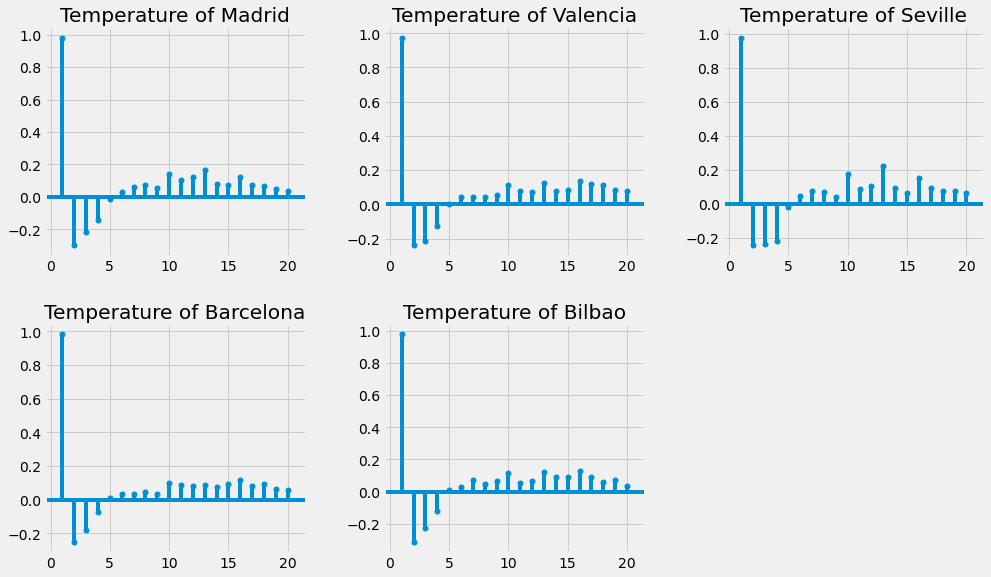

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,9))

x = plot_pacf(temp['Madrid'], alpha=0.05, lags=20, zero=False, ax = axs[0,0])
axs[0,0].set_title('Temperature of Madrid')

x = plot_pacf(temp['Valencia'], alpha=0.05, lags=20, zero=False, ax = axs[0,1])
axs[0,1].set_title('Temperature of Valencia')

x = plot_pacf(temp['Seville'], alpha=0.05, lags=20, zero=False, ax = axs[0,2])
axs[0,2].set_title('Temperature of Seville')

x = plot_pacf(temp['Barcelona'], alpha=0.05, lags=20, zero=False, ax = axs[1,0])
axs[1,0].set_title('Temperature of Barcelona')

x = plot_pacf(temp['Bilbao'], alpha=0.05, lags=20, zero=False, ax = axs[1,1])
axs[1,1].set_title('Temperature of Bilbao')

axs[1,2].remove()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Modeling using Linear Regression 

In [ ]:
Madrid_temp = temp[['Madrid']]

In [ ]:
for i in range(1, 10): 
    Madrid_temp["lag_{}".format(i)] = Madrid_temp.Madrid.shift(i) 
print("done") 

done
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Madrid_temp.head(5) 

city_name,Madrid,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
time,,,,,,,,,,
2014-12-31 23:00:00,21.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00,21.515,21.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,19.465,21.515,21.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,19.465,19.465,21.515,21.515,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,19.465,19.465,19.465,21.515,21.515,NaN,NaN,NaN,NaN,NaN


In [ ]:
Madrid_temp.shape

(35064, 10)

In [ ]:
X = Madrid_temp.dropna()
X = X.iloc[-192:,1:]
X.shape

(192, 9)

In [ ]:
y = Madrid_temp.dropna().Madrid.iloc[-192:].to_frame()
y.shape

(192, 1)

In [ ]:
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X, y, 0.125)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

(array([17889., 17890., 17891., 17892., 17893., 17894., 17895., 17896.,
        17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

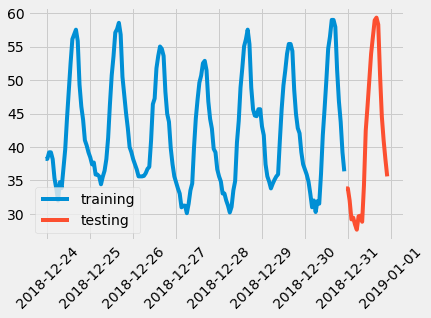

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_train, label='training')
ax.plot(y_test,label='testing')
ax.legend()
plt.xticks(rotation=45)

In [ ]:
y_predict = regressor.predict(X_test)
y_predict = pd.DataFrame(y_predict, index=y_test.index, columns=['prediction'])

In [ ]:
df = y_test.join(y_predict)
df

,Madrid,prediction
time,,
2018-12-30 23:00:00,33.800,33.993718
2018-12-31 00:00:00,33.800,31.914628
2018-12-31 01:00:00,32.000,33.507486
2018-12-31 02:00:00,29.174,31.656780
2018-12-31 03:00:00,29.426,28.778682
2018-12-31 04:00:00,28.400,30.189544
2018-12-31 05:00:00,27.626,29.508821
2018-12-31 06:00:00,29.642,29.315268
2018-12-31 07:00:00,29.714,32.279145


(array([17889., 17890., 17891., 17892., 17893., 17894., 17895., 17896.,
        17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

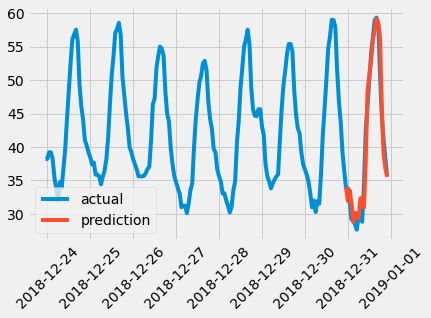

In [ ]:
fig, ax = plt.subplots()
ax.plot(y, label='actual')
ax.plot(df['prediction'], label='prediction')
ax.legend()
plt.xticks(rotation=45)

In [ ]:
mean_absolute_error(df['Madrid'], df['prediction'])

1.7153659558655798

In [ ]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, columns=X_train.columns)
    coefs = coefs.transpose()
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.xticks(rotation=45)
    plt.xlabel('Lags')
    plt.title('Coefficients of the Lags')

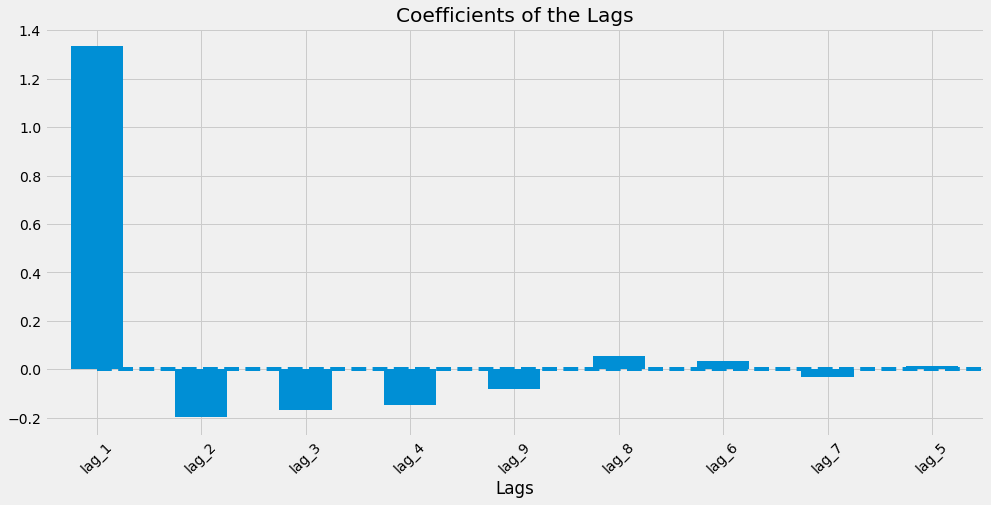

In [ ]:
plotCoefficients(regressor)

### Modeling using SARIMA

#### Train and Test split

168
24


(array([17889., 17890., 17891., 17892., 17893., 17894., 17895., 17896.,
        17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

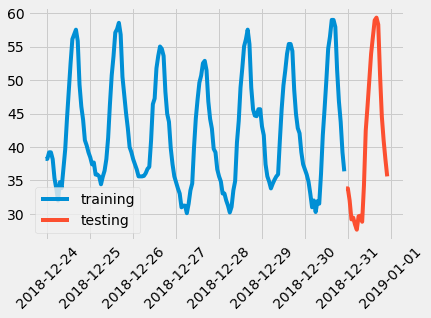

In [ ]:
temp = pd.pivot_table(weather, values='temp', columns='city_name', index='time')
train = temp['Madrid'][-192:-24]
test = temp['Madrid'][-24:]
print(len(train.values))
print(len(test.values))
fig, ax = plt.subplots()
ax.plot(train, label='training')
ax.plot(test, label='testing')
ax.legend()
plt.xticks(rotation=45)

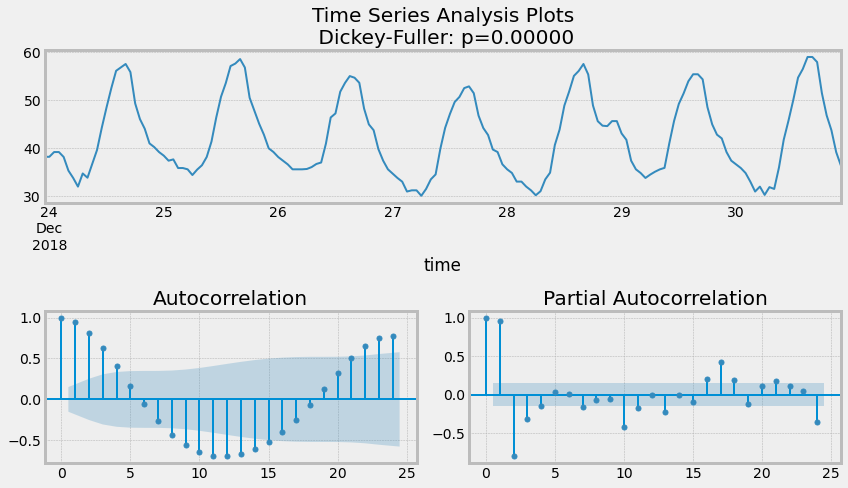

In [ ]:
tsplot(train, lags=24)

In [ ]:
model_result = pm.auto_arima(train, d = 0, start_p = 0, max_p = 3, 
    start_q = 0, max_q = 0, seasonal = True, m = 24, D = 0, start_P = 0, max_P = 3, start_Q = 0, max_Q = 0)
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 24)   Log Likelihood                -283.482
Date:                            Sat, 26 Jun 2021   AIC                            578.965
Time:                                    14:02:32   BIC                            597.709
Sample:                                         0   HQIC                           586.572
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2913      0.445      2.903      0.004       0.420       2.163
ar.L1          1.0809      0.079     13.596      0.000       0.925       1.237
ar.L2          0.2000      0.118      1.691      0.091      -0.032       0.432
ar.L3         -0.4073      0.067     -6.041      0.000      -0.539      -0.275
ar.S.L24       0.7623      0.053     14.288      0.000       0.658       0.867
sigma2         1.5154      0.171      8.852      0.000       1.180       1.851
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.80   Prob(JB):                         0.88
Heteroskedasticity (H):               2.13   Skew:                            -0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train

time
2018-12-23 23:00:00    38.210
2018-12-24 00:00:00    38.210
2018-12-24 01:00:00    39.200
2018-12-24 02:00:00    39.200
2018-12-24 03:00:00    38.174
                        ...  
2018-12-30 18:00:00    51.476
2018-12-30 19:00:00    46.832
2018-12-30 20:00:00    43.736
2018-12-30 21:00:00    39.182
2018-12-30 22:00:00    36.356
Name: Madrid, Length: 168, dtype: float64

In [ ]:
test

time
2018-12-30 23:00:00    33.800
2018-12-31 00:00:00    33.800
2018-12-31 01:00:00    32.000
2018-12-31 02:00:00    29.174
2018-12-31 03:00:00    29.426
2018-12-31 04:00:00    28.400
2018-12-31 05:00:00    27.626
2018-12-31 06:00:00    29.642
2018-12-31 07:00:00    29.714
2018-12-31 08:00:00    28.814
2018-12-31 09:00:00    34.232
2018-12-31 10:00:00    42.458
2018-12-31 11:00:00    46.094
2018-12-31 12:00:00    50.000
2018-12-31 13:00:00    53.942
2018-12-31 14:00:00    56.462
2018-12-31 15:00:00    58.946
2018-12-31 16:00:00    59.342
2018-12-31 17:00:00    58.298
2018-12-31 18:00:00    50.738
2018-12-31 19:00:00    44.546
2018-12-31 20:00:00    41.000
2018-12-31 21:00:00    38.156
2018-12-31 22:00:00    35.600
Name: Madrid, dtype: float64

In [ ]:
model = SARIMAX(train, order=(3,0,0), seasonal_order=(1,0,0,24), trend='c')

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [ ]:
fit_res = model.fit(disp=False, maxiter=250)
res = model.filter(fit_res.params)

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [ ]:
predict_dy = res.get_prediction(start='2018-12-24 00:00:00')
predict_dy_ci = predict_dy.conf_int()

In [ ]:
forecast = res.forecast(24)

In [ ]:
predict_dy

<AxesSubplot:>

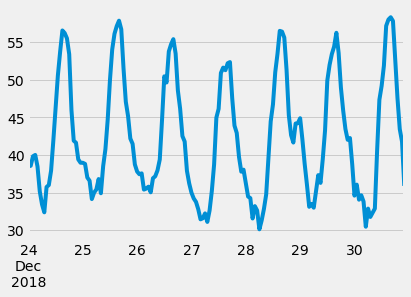

In [ ]:
predict_dy.predicted_mean.plot()

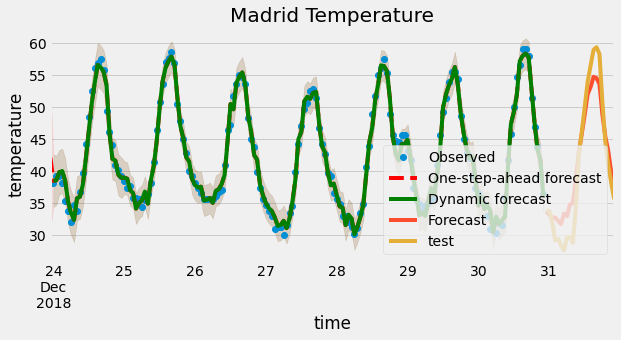

In [ ]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Madrid Temperature', xlabel='Date', ylabel='temperature')

# Plot data points
train.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast')
ci = predict_dy_ci
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
forecast.plot(ax=ax, label='Forecast')
test.plot(ax=ax, label='test')

legend = ax.legend(loc='lower right')

In [ ]:
# def plotSARIMA(series, model, n_steps):
#     """
#         Plots model vs predicted values
        
#         series - dataset with timeseries
#         model - fitted SARIMA model
#         n_steps - number of steps to predict in the future
        
#     """
#     # adding model values
#     data = series.copy()
#     data.columns = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN
    
#     # forecasting on n_steps forward 
#     forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#     forecast = data.arima_model.append(forecast)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
#     plt.plot(forecast, color='r', label="model")
#     plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
#     plt.plot(data.actual, label="actual")
#     plt.legend()
#     plt.grid(True);

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



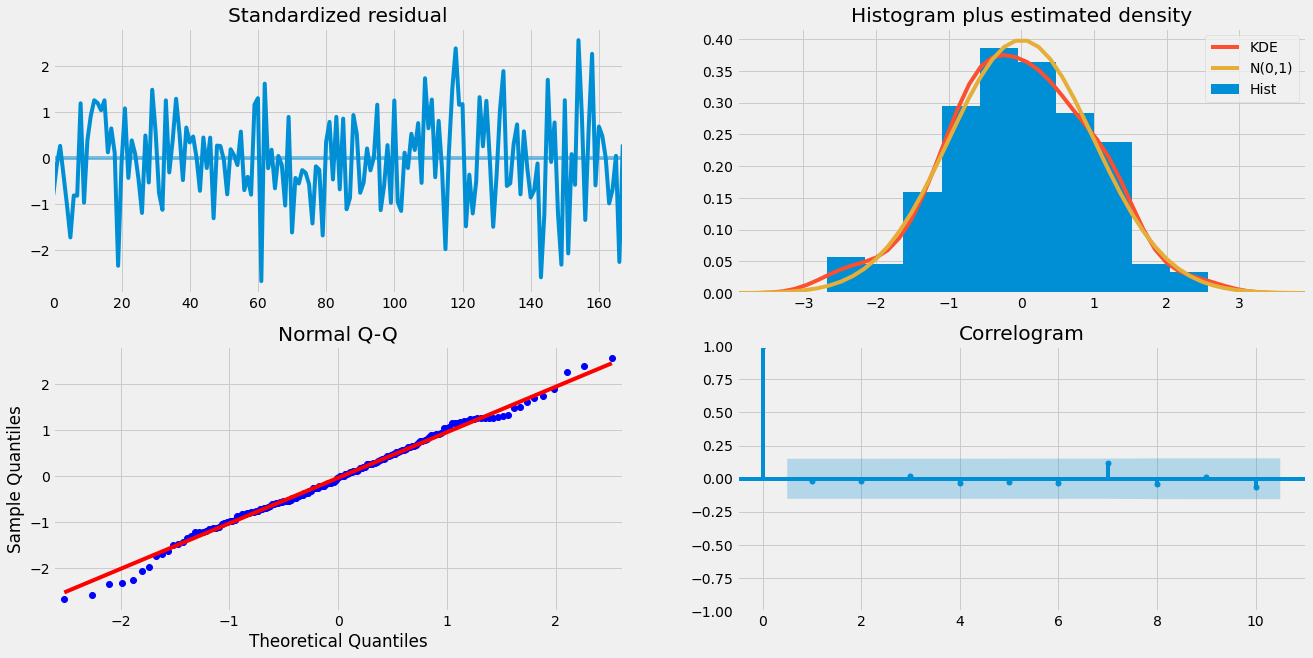

In [ ]:
X = model_result.plot_diagnostics()
plt.gcf().set_size_inches(20, 10)

In [ ]:
prediction = pd.DataFrame(model_result.predict(n_periods=24), index = test.index)
prediction.columns = ['Predicted Temperature']

(array([17889., 17890., 17891., 17892., 17893., 17894., 17895., 17896.,
        17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

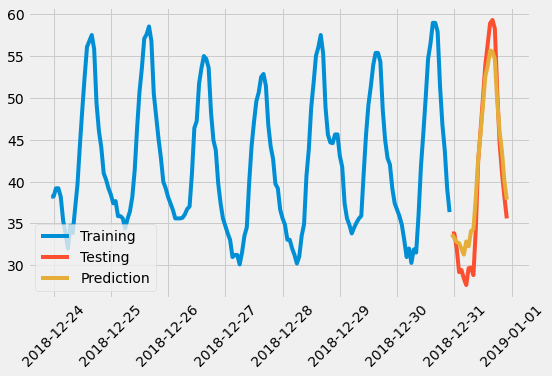

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Testing')
plt.plot(prediction, label = 'Prediction')
plt.legend(loc='best')
plt.xticks(rotation=45)

In [ ]:
mean_absolute_error(test.values, prediction['Predicted Temperature'])

2.377362476876709

### Forecasting 
* In-sample forecasting
* Dynamic forecasting
* Out of sample forecasting

In [ ]:
Madrid_temp = temp[['Madrid']]
Jan_2015 = Madrid_temp[(Madrid_temp.index.year == 2015) & (Madrid_temp.index.month == 1)]

In [ ]:
model_result = pm.auto_arima(Jan_2015, d = 0, start_p = 0, max_p = 3, 
    start_q = 0, max_q = 0, seasonal = True, m = 24, D = 0, start_P = 0, max_P = 3, start_Q = 0, max_Q = 0)

In [ ]:
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -1901.787
Date:                            Sat, 26 Jun 2021   AIC                           3813.575
Time:                                    14:05:10   BIC                           3836.635
Sample:                                         0   HQIC                          3822.463
                                            - 744                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6286      0.193      3.250      0.001       0.250       1.008
ar.L1          0.9560      0.013     74.188      0.000       0.931       0.981
ar.S.L24       0.4419      0.018     23.982      0.000       0.406       0.478
ar.S.L48       0.2218      0.020     11.068      0.000       0.183       0.261
sigma2         9.5335      0.225     42.424      0.000       9.093       9.974
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              6982.03
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# in-sample prediction
model = SARIMAX(Jan_2015, order=(1,0,0), seasonal_order=(2,0,0,24), trend='c')
results = model.fit()
forecast = results.get_prediction(start=-168)
mean_forecast = forecast.predicted_mean
conf_interval = forecast.conf_int()

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



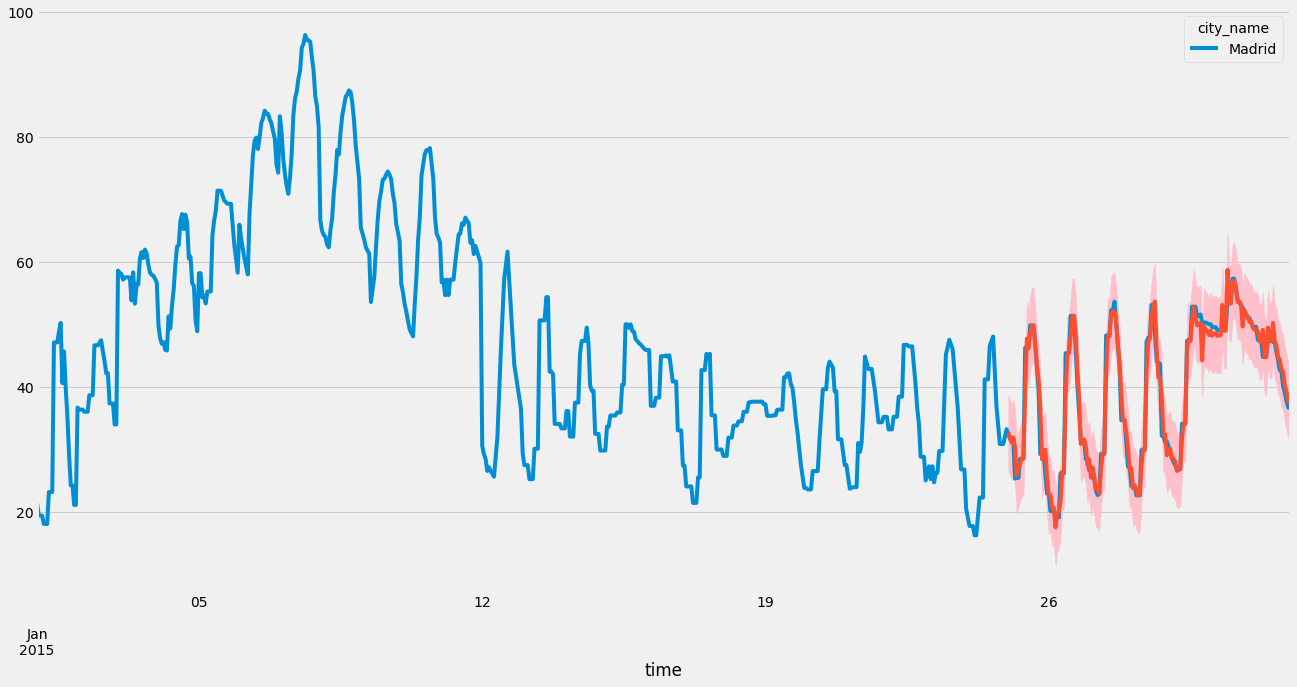

In [ ]:
ax = Jan_2015.plot()
mean_forecast.plot(ax = ax)
plt.fill_between(mean_forecast.index, conf_interval['lower Madrid'], conf_interval['upper Madrid'], color='pink')
plt.gcf().set_size_inches(20, 10)

In [ ]:
forecast = results.get_prediction(start=-168, dynamic=True) 
mean_forecast = forecast.predicted_mean
conf_interval = forecast.conf_int()

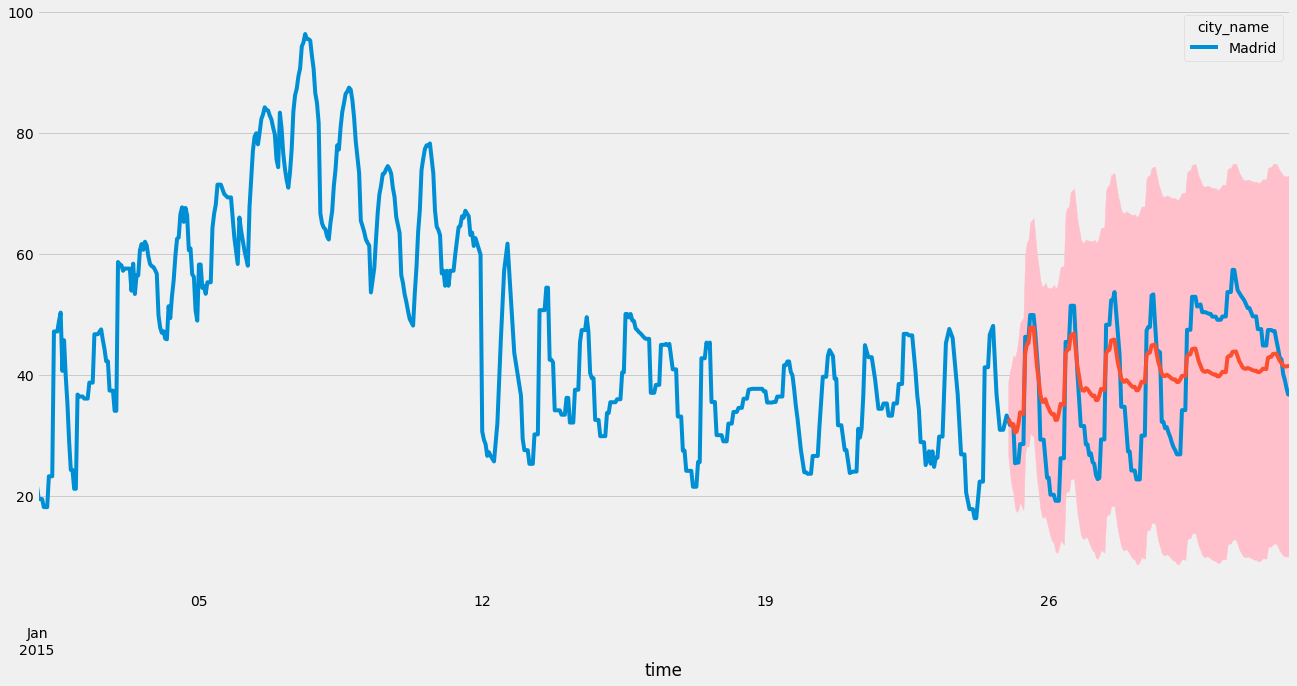

In [ ]:
ax = Jan_2015.plot()
mean_forecast.plot(ax = ax)
plt.fill_between(mean_forecast.index, conf_interval['lower Madrid'], conf_interval['upper Madrid'], color='pink')
plt.gcf().set_size_inches(20, 10)

### Forecast out of sample 

In [ ]:
test = Madrid_temp[(Madrid_temp.index.year == 2015) & (Madrid_temp.index.month == 2) & (Madrid_temp.index.day == 1)]

AttributeError: 'property' object has no attribute 'plot'

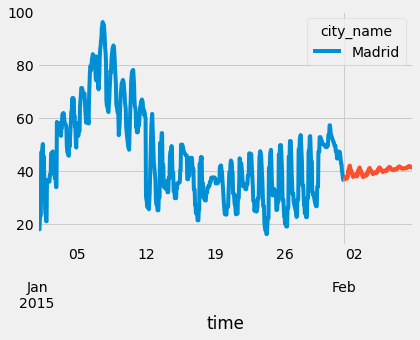

In [ ]:
forecast = results.get_forecast(steps=168) 
# forecast mean 
mean_forecast = forecast.predicted_mean 
# confidence interval 
confidence_intervals = forecast.conf_int() 

ax = Jan_2015.plot() 
mean_forecast.plot(ax = ax) 
test.plot(ax = ax) 
plt.fill_between(mean_forecast.index, confidence_intervals['lower Madrid'], confidence_intervals['upper Madrid'], color='pink')
plt.gcf().set_size_inches(20, 10) 

In [ ]:
mean_absolute_error(test.values, mean_forecast)

11.516171337258598

### LSTM

#### Split the data
70%, 20%, and 10%

In [ ]:
Madrid = Madrid.iloc[-240:,:]
Madrid.reset_index(inplace = True)

In [ ]:
date_time = pd.to_datetime(Madrid.pop('time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
Madrid.drop(columns=['city_name'], inplace=True)
column_indices = {name: i for i, name in enumerate(Madrid.columns)}
# print(column_indices)
n = len(Madrid)
# print(n)
train_df = Madrid[0:int(n*0.7)]
val_df = Madrid[int(n*0.7):int(n*0.9)]
test_df = Madrid[int(n*0.9):]

num_features = Madrid.shape[1]

#### Normalizaiton
mean and std are only calculated using the training dataset `train_df`

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

distribution of features using boxplot

#### Data windowing

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Temperature'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Temperature']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['temp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temp']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Testing:

In [ ]:
w2.total_window_size

7

In [ ]:
train_df = np.asarray(train_df).astype('float64')
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[7:7+w2.total_window_size]),
                           np.array(train_df[14:14+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 12)
Inputs shape: (3, 6, 12)
labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

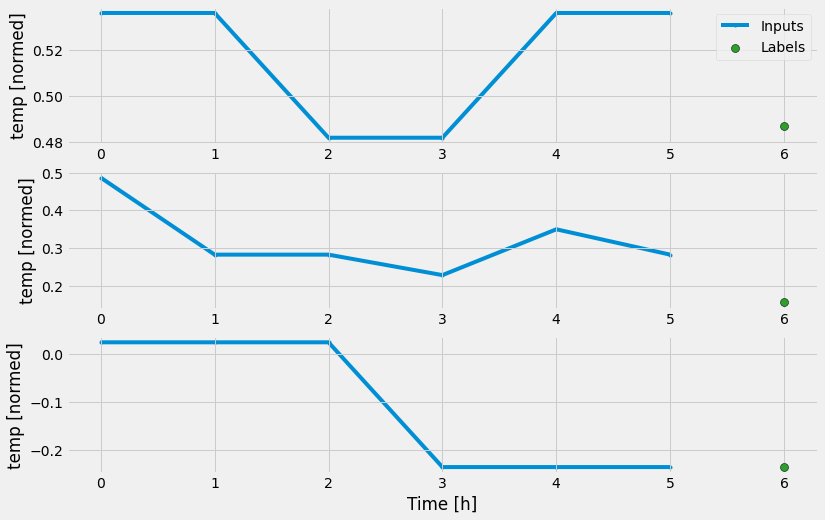

In [ ]:
w2.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temp'])
print(wide_window)
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']
Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
baseline = Baseline(label_index=column_indices['temp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 63ms/step - loss: nan - mean_absolute_error: nan


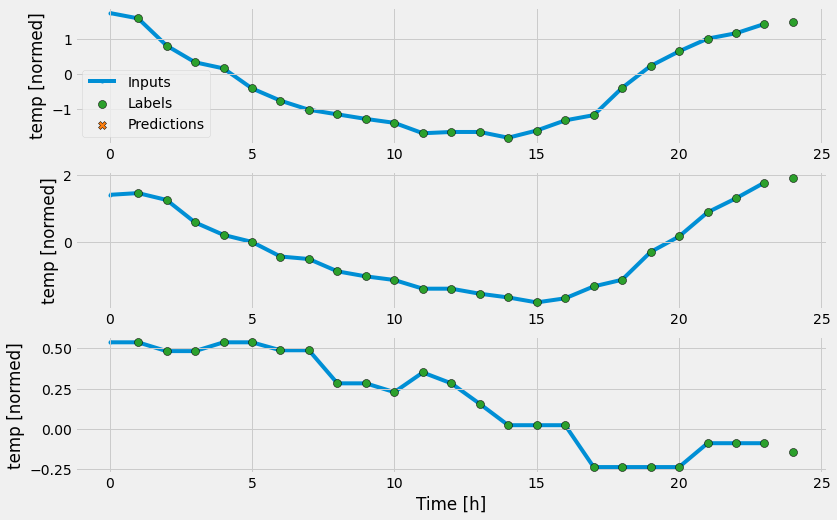

In [ ]:
wide_window.plot(lstm_model)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1638dc94-e6d7-43b6-8bef-1d6183fef075' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>